# Scope
To train frequency nadir and VSG power peak with generated data

```
Note: 
1）add negtive part to the original data and shuffle; *** To be solved: add dPe as input? ***
2）remember to normalize and denormalize input/output while using the neural network.
```


## Load data and normalization

In [45]:
import torch
import pandas as pd
import numpy as np
import copy
from torch import nn
from d2l import torch as d2l
import matplotlib
import matplotlib.pyplot as plt

In [46]:
# load data
data_fnadir = pd.read_csv('fnadir.txt', dtype=float, header=None).values
data_Ppeak = pd.read_csv('Ppeak.txt', dtype=float, header=None).values
print(f'Data dimention: {data_fnadir.shape}')

# Normalization
fnadir_mean = np.mean(data_fnadir, axis=0)
fnadir_std = np.std(data_fnadir, axis=0)
fnadir_norm = (data_fnadir - fnadir_mean)/fnadir_std

Ppeak_mean = np.mean(data_Ppeak, axis=0)
Ppeak_std = np.std(data_Ppeak, axis=0)
Ppeak_norm = (data_Ppeak - Ppeak_mean)/Ppeak_std

Data dimention: (20000, 5)


In [47]:
# add negative part
fnadir_norm = np.concatenate((fnadir_norm, -fnadir_norm), axis=0)
Ppeak_norm = np.concatenate((Ppeak_norm, -Ppeak_norm), axis=0)

# fnadir_norm.shape

## Construct neural network


In [48]:
# ini MLP neural network
net_fnadir = nn.Sequential(nn.Linear(4, 64),
                          nn.ReLU(),
                          nn.Linear(64, 1))

net_Ppeak = nn.Sequential(nn.Linear(6, 64),
                          nn.ReLU(),
                          nn.Linear(64, 1))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_fnadir.apply(init_weights)
net_Ppeak.apply(init_weights)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
)

## Training

In [49]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Use Adam optimizer
    optimizer = torch.optim.SGD(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(loss(net(train_features),train_labels).item())
        if test_labels is not None:
            test_ls.append(loss(net(test_features),test_labels).item())
    return train_ls, test_ls

In [50]:
# shuffle training data
np.random.shuffle(fnadir_norm)
np.random.shuffle(Ppeak_norm)

### Train fnadir network 

In [51]:
# Split as training and test data
split_num = int(0.95 * fnadir_norm.shape[0]) # 0.95 means 95% as training data
print(f'95% as training data, 5% as test data')

train_data, test_data = fnadir_norm[0:split_num, ...].copy(), fnadir_norm[split_num:-1, ...].copy()
print(f'Training data dimention: {train_data.shape}')
print(f'Test data dimention: {test_data.shape}')

train_feature = train_data[:, 0:4]
train_label = train_data[:, -1]
train_label = np.expand_dims(train_label, axis=1)

test_feature = test_data[:, 0:4]
test_label = test_data[:, -1]
test_label = np.expand_dims(test_label, axis=1)

95% as training data, 5% as test data
Training data dimention: (38000, 5)
Test data dimention: (1999, 5)


In [52]:
# train_feature

In [53]:
# convert np array to torch tensor
train_feature = torch.tensor(train_feature, dtype=torch.float32)
train_label = torch.tensor(train_label, dtype=torch.float32)
test_feature = torch.tensor(test_feature, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32)

In [54]:
# training hyperparameter
batch_size, lr, num_epochs, weight_decay = 128, 0.05, 300, 0
loss = nn.MSELoss()

# train
training_ls, validation_ls = train(net_fnadir, train_feature, train_label, test_feature, test_label, \
    num_epochs, lr, weight_decay, batch_size)

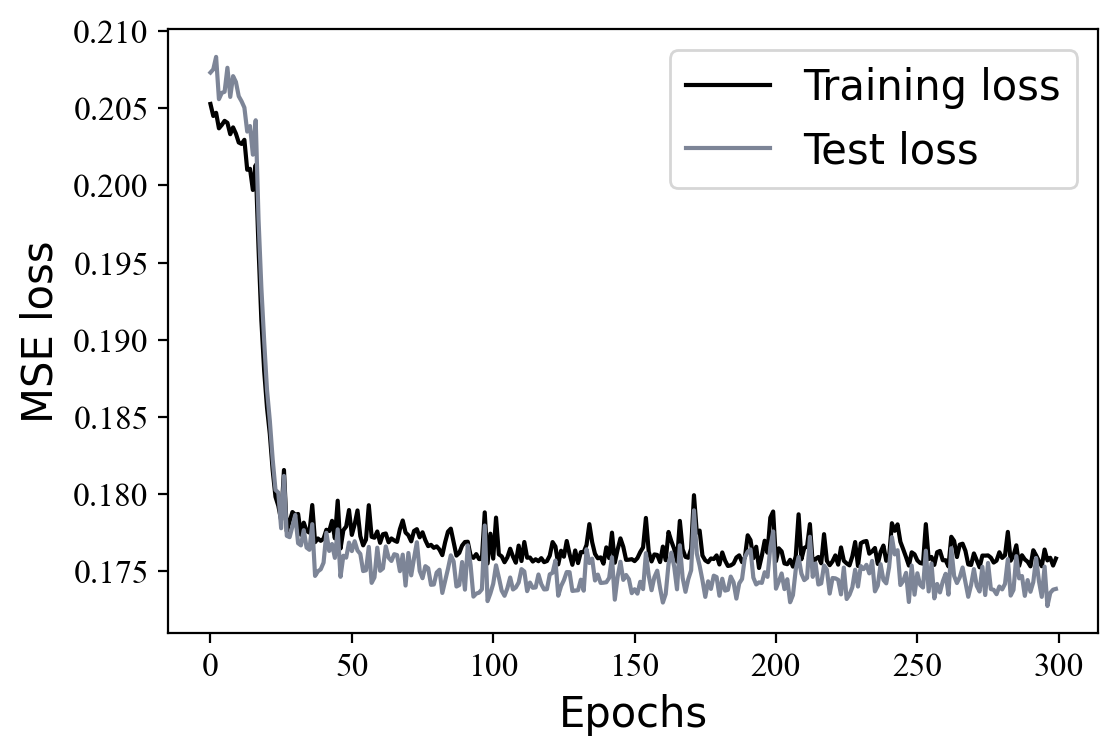

In [55]:
# plot training loss
fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
plt.grid(color='white')

figP = ax.plot(training_ls, label='training loss', linewidth=1.5, c='black')
figQ = ax.plot(validation_ls, label='test loss', linewidth=1.5, c='#7d8597')
# ax.set_ylim([-0.02, 0.55])
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('MSE loss', color = 'black', fontsize=15)
ax.tick_params(axis='y', labelcolor='black')
ax.legend(['Training loss', 'Test loss'], fontsize=15)

In [56]:
# Export neural network model
model_scripted = torch.jit.script(net_fnadir) # Export to TorchScript
model_scripted.save('net_fnadir.pt') # Save

### Train Ppeak network

In [57]:
train_data, test_data = Ppeak_norm[0:split_num, ...].copy(), Ppeak_norm[split_num:-1, ...].copy()
print(f'Training data dimention: {train_data.shape}')
print(f'Test data dimention: {test_data.shape}')

train_feature = train_data[:, 0:6]
train_label = train_data[:, -1]
train_label = np.expand_dims(train_label, axis=1)

test_feature = test_data[:, 0:6]
test_label = test_data[:, -1]
test_label = np.expand_dims(test_label, axis=1)

# convert np array to torch tensor
train_feature = torch.tensor(train_feature, dtype=torch.float32)
train_label = torch.tensor(train_label, dtype=torch.float32)
test_feature = torch.tensor(test_feature, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32)

Training data dimention: (38000, 7)
Test data dimention: (1999, 7)


In [58]:
# training hyperparameter
batch_size, lr, num_epochs, weight_decay = 128, 0.05, 300, 0
loss = nn.MSELoss()

# train
training_ls, validation_ls = train(net_Ppeak, train_feature, train_label, test_feature, test_label, \
    num_epochs, lr, weight_decay, batch_size)

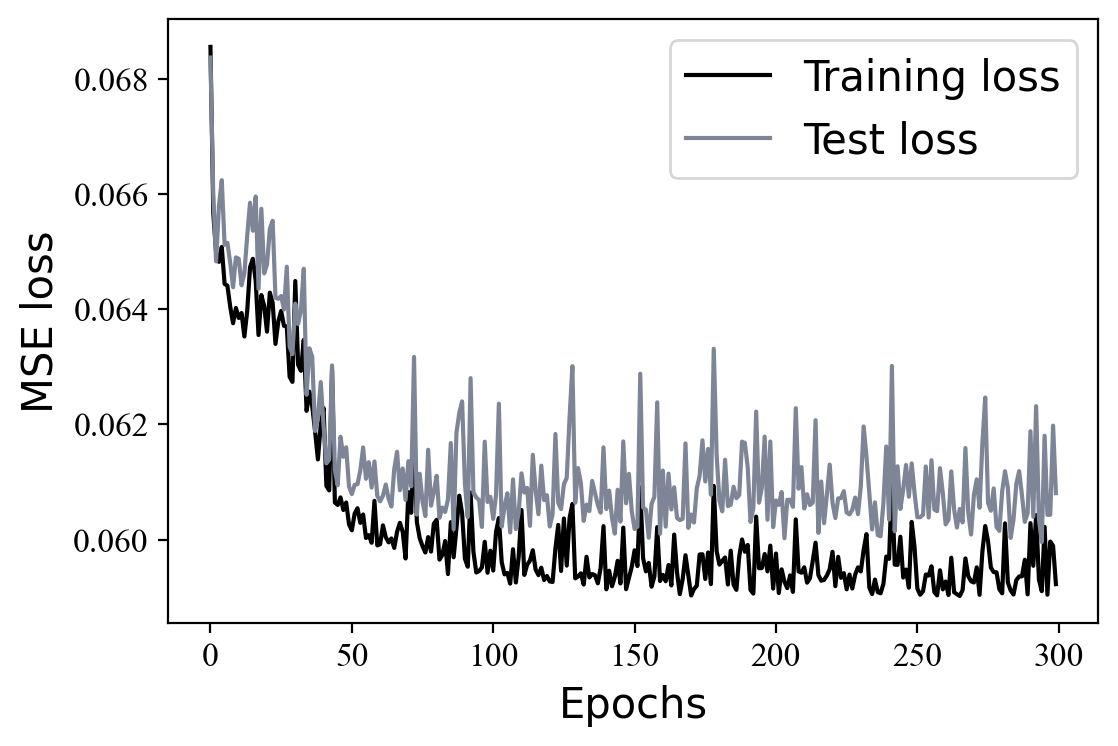

In [59]:
# plot training loss
fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
plt.grid(color='white')

figP = ax.plot(training_ls, label='training loss', linewidth=1.5, c='black')
figQ = ax.plot(validation_ls, label='test loss', linewidth=1.5, c='#7d8597')
# ax.set_ylim([-0.02, 0.55])
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('MSE loss', color = 'black', fontsize=15)
ax.tick_params(axis='y', labelcolor='black')
ax.legend(['Training loss', 'Test loss'], fontsize=15)

In [60]:
# Export neural network model
model_scripted = torch.jit.script(net_Ppeak) # Export to TorchScript
model_scripted.save('net_Ppeak.pt') # Save

## Export data used in optimization

## 1. export norm data

In [61]:
fnorm = np.array([fnadir_mean, fnadir_std])
fnorm

array([[ 1.49881796e+01,  7.49287393e+00,  8.00451262e+01,
         1.24959573e+02, -1.38601155e-02],
       [ 2.89150117e+00,  1.43862831e+00,  4.03507841e+01,
         4.35466004e+01,  6.38745635e-03]])

In [62]:
pnorm = np.array([Ppeak_mean, Ppeak_std])
pnorm

array([[1.49881796e+01, 7.49287393e+00, 8.00451262e+01, 1.24959573e+02,
        4.01849330e+00, 2.00460233e+00, 1.43187785e-01],
       [2.89150117e+00, 1.43862831e+00, 4.03507841e+01, 4.35466004e+01,
        2.31765651e+00, 1.15136376e+00, 8.63129418e-02]])

In [63]:
# data norm
pd.DataFrame(fnorm).to_csv("fnorm.csv", header=['M','D','Fg','Rg','fnadir'], index=False)
pd.DataFrame(pnorm).to_csv("pnorm.csv", header=['M','D','Fg','Rg','Mvsg','Dvsg','Ppeak'], index=False)

## 2. test netowrk parameters (exprot using 'Output_nn.ipynb')

In [64]:
# net_fnadir and net_Ppeak
Layer = []
for layer in net_fnadir.children():
    Layer.append(layer)

In [65]:
Layer

[Linear(in_features=4, out_features=64, bias=True),
 ReLU(),
 Linear(in_features=64, out_features=1, bias=True)]

In [66]:
Layer[0].state_dict()['weight'].detach().numpy()

array([[ 7.02364184e-03, -9.03179962e-03, -3.72516899e-03,
         2.79065949e-04],
       [ 1.19371535e-02, -4.67841420e-03,  1.04979239e-01,
         9.24885739e-03],
       [-2.13159490e-02,  1.18896377e-03, -5.65543398e-02,
        -1.56702939e-02],
       [-1.27524193e-02, -3.67993431e-04, -6.21710205e-03,
         4.01126547e-03],
       [-1.55083323e-02,  2.00229771e-02, -1.25957593e-01,
        -1.57016516e-02],
       [ 4.34052385e-03,  1.53116267e-02,  1.71358492e-02,
        -2.32107146e-03],
       [ 2.53332481e-02,  1.00950124e-02,  1.20155758e-03,
         1.92712899e-03],
       [ 3.44131663e-02, -6.09936425e-03,  1.93010747e-01,
         1.84782390e-02],
       [ 1.34622427e-02,  4.10528993e-03, -2.11050780e-03,
         6.86428510e-03],
       [-1.79094188e-02,  4.98705544e-03, -1.24874990e-02,
        -2.08624173e-03],
       [ 8.41754116e-03, -1.02066649e-02,  1.64609384e-02,
         1.08272275e-02],
       [ 9.70127340e-03, -2.11446569e-03,  9.46360230e-02,
      